### In this section, I will explore the dataset:
1. **Check for Sensitive Information**
   Look for any potential PII, payment card details, or other confidential data.
   Even one piece of problematic data can spoil the entire system.

2. **Identify Preprocessing Needs**
   Look for different language other than English.
   Determine what cleaning or transformation steps will improve the dataset’s usability.

3. **Review Basic Statistics**
   Analyze size, distributions, and other key metrics to decide on an effective chunking strategy.

4. **Planing next stage**
   Preview example entries to plan an appropriate indexing approach for the RAG system.

In [4]:
import re
import json
from pathlib import Path
import time
import random
import warnings
import langid
from bs4 import BeautifulSoup

In [2]:
# This function will load the json file to json object
def load_json_list(path: str):    
    with open(path, mode = "r", encoding="utf-8") as f:
        return json.load(f)

In [3]:
data = load_json_list(r"datasets\medlineplus_drugs.json")

In [5]:
data[:1]

[{'id': 1,
  'drug_name': 'Phenylephrine',
  'pronunciation': "pronounced as (fen il ef' rin)",
  'url': 'https://medlineplus.gov/druginfo/meds/a606008.html',
  'subtitles': [{'title': 'Why is this medication prescribed?',
    'content': '<div class="section-body" id="section-1"><p>Phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. It is also used to relieve sinus congestion and pressure. Phenylephrine will relieve symptoms but will not treat the cause of the symptoms or speed recovery. Phenylephrine is in a class of medications called nasal decongestants. It works by reducing swelling of the blood vessels in the nasal passages.</p></div>'},
   {'title': 'How should this medicine be used?',
    'content': '<div class="section-body" id="section-2"><p>Phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. It is usually taken every 4 hours as needed. Follow the directions on your prescription label or the package label 

In [12]:
# Cleaning html tag for sub-content
# testing basic function
def remove_html_tag(html: str):
    return BeautifulSoup(html, "html.parser").get_text(separator="", strip=True)

In [ ]:
html = '''"<div class=\"section-body\" id=\"section-2\"><p>Phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. It is usually taken every 4 hours as needed. Follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not understand. Take phenylephrine exactly as directed. Do not take more or less of it or take it more often than prescribed by your doctor or directed on the label.</p><p>Phenylephrine comes alone and in combination with other medications. Ask your doctor or pharmacist for advice on which product is best for your symptoms. Check nonprescription cough and cold product labels carefully before using two or more products at the same time. These products may contain the same active ingredient(s) and taking them together could cause you to receive an overdose. This is especially important if you will be giving cough and cold medications to a child.</p><p>Nonprescription cough and cold combination products, including products that contain phenylephrine, can cause serious side effects or death in young children. Do not give these products to children younger than 4 years of age. If you give these products to children 4 to 11 years of age, use caution and follow the package directions carefully.</p><p>If you are giving phenylephrine or a combination product that contains phenylephrine to a child, read the package label carefully to be sure that it is the right product for a child of that age. Do not give phenylephrine products that are made for adults to children.</p><p>Before you give a phenylephrine product to a child, check the package label to find out how much medication the child should receive. Give the dose that matches the child's age on the chart. Ask the child's doctor if you don't know how much medication to give the child.</p><p>If you are taking the liquid, do not use a household spoon to measure your dose. Use the measuring spoon or cup that came with the medication or use a spoon made especially for measuring medication.</p><p>If your symptoms do not get better within 7 days or if you have a fever, stop taking phenylephrine and call your doctor.</p><p>If you are taking the dissolving strips, place one strip on your tongue and allow it to dissolve.</p></div>"'''
text = remove_html_tag(html)
print(text)


"Phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. It is usually taken every 4 hours as needed. Follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not understand. Take phenylephrine exactly as directed. Do not take more or less of it or take it more often than prescribed by your doctor or directed on the label.Phenylephrine comes alone and in combination with other medications. Ask your doctor or pharmacist for advice on which product is best for your symptoms. Check nonprescription cough and cold product labels carefully before using two or more products at the same time. These products may contain the same active ingredient(s) and taking them together could cause you to receive an overdose. This is especially important if you will be giving cough and cold medications to a child.Nonprescription cough and cold combination products, including products that contain 

In [15]:
for d in data:
    for t in d["subtitles"]:        
        t["content"] = remove_html_tag(t["content"])

In [16]:
# Sensitive info checking
# This function will replace PII string with other string
def remove_pii(text):
    text = re.sub(r'\b[\w.-]+?@\w+?\.\w{2,4}\b', '[EMAIL]', text)
    text = re.sub(r'\b(?:\d[ -]*?){13,16}\b', '[CREDIT_CARD]', text)
    text = re.sub(r'\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3,4}[-.\s]?\d{4}\b', '[PHONE]', text)
    return text

def warn_if_pii(text: str):
    """
    Scan the input text for emails, credit card numbers, or phone numbers.
    If any are found, issue a warning and display the full text.
    """
    # Compile regex patterns
    email_pattern = re.compile(r'\b[\w.-]+?@\w+?\.\w{2,4}\b')
    credit_pattern = re.compile(r'\b(?:\d[ -]*?){13,16}\b')
    phone_pattern = re.compile(
        r'\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3,4}[-.\s]?\d{4}\b'
    )

    # Find matches
    emails = email_pattern.findall(text)
    credits = credit_pattern.findall(text)
    phones = phone_pattern.findall(text)

    # If any matches exist, warn with details
    if emails or credits or phones:
        matches = {
            "emails": emails,
            "credit_cards": credits,
            "phones": phones
        }
        warnings.warn(
            f"Possible PII detected: {matches}\nFull text:\n{text}",
            category=UserWarning
        )        

In [17]:
s = "slslskdskkshhf text@gmail.com lslklsjsldfss,fstext@gmail.com sd893sdflllsl 12341234432132 lsklgallklklsdhg75434lskdkdk 4321-4321-4352-321 sjlasfkl5146996266sljlslls"
# Test the functionality
warn_if_pii(s)

C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\686340581.py:33: UserWarning: Possible PII detected: {'emails': ['text@gmail.com', 'fstext@gmail.com'], 'credit_cards': ['12341234432132', '4321-4321-4352-321'], 'phones': ['12341234432132', '4321-4321-4352']}
Full text:
slslskdskkshhf text@gmail.com lslklsjsldfss,fstext@gmail.com sd893sdflllsl 12341234432132 lsklgallklklsdhg75434lskdkdk 4321-4321-4352-321 sjlasfkl5146996266sljlslls
  warnings.warn(


In [18]:
# Check if it contains PII
for d in data[:200]:
    for t in d["subtitles"]:
        warn_if_pii(t["title"])
        warn_if_pii(t["content"])

C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\686340581.py:33: UserWarning: Possible PII detected: {'emails': [], 'credit_cards': [], 'phones': ['1-800-332-1088']}
Full text:
Phenylephrine may cause side effects. Some side effects can be serious. If you experience any of these symptoms, stop using phenylephrine and call your doctor:nervousnessdizzinesssleeplessnessPhenylephrine may cause other side effects. Call your doctor if you have any unusual problems while taking this medication.If you experience a serious side effect, you or your doctor may send a report to the Food and Drug Administration's (FDA) MedWatch Adverse Event Reporting program online (https://www.fda.gov/Safety/MedWatch) or by phone (1-800-332-1088).
  warnings.warn(
C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\686340581.py:33: UserWarning: Possible PII detected: {'emails': [], 'credit_cards': [], 'phones': ['1-800-222-1222']}
Full text:
In case of overdose, call the poison control helpline at 1-800-222-1222.

In [19]:
# The phone looks like public number. I don't think it is PII. But it is useless, so remove it.
for d in data:
    for t in d["subtitles"]:
        t["title"] = remove_pii(t["title"])
        t["content"] = remove_pii(t["content"])

In [20]:
# Check one more time just in case 
for d in data[:200]:
    for t in d["subtitles"]:
        warn_if_pii(t["title"])
        warn_if_pii(t["content"])

In [21]:
# Check if it contains other language content besides English.
def warn_if_otherlang(text: str, lang="en"):

    detected_lang, confidence = langid.classify(text)    
    if lang != detected_lang:
        warnings.warn(
            f"Other language {detected_lang} detected in: {text}\n",
            category=UserWarning
        )    


def filter_by_language(text, lang="en"):
    detected_lang, confidence = langid.classify(text)    
    if lang != detected_lang:
        return ""
    
    return text

In [22]:
for d in data[100:150]:
    for t in d["subtitles"]:
        warn_if_otherlang(t['title'])
        warn_if_otherlang(t["content"])

C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\3604922057.py:6: UserWarning: Other language es detected in: Keep your vaccination card

  warnings.warn(
C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\3604922057.py:6: UserWarning: Other language es detected in: Adenoviral vector COVID-19 vaccineAdenovirus 26 vector COVID-19 vaccineAd26.COV2.SCOVID-19 Vaccine, Johnson and Johnson

  warnings.warn(


##### As this is the medicine data, it is normal to contains some other languages like latín.
##### So I will not replace that content in the project

##### Next **Identify Preprocessing Needs**

In [14]:
# Now check how many distinct title the whole data has
titles_set = set([t['title'] for d in data for t in d["subtitles"]])

In [17]:
sorted(titles_set, key=len, reverse=True)

['Can I be charged an administration fee for receiving the COVID-19 vaccine?',
 'What are the risks from inactivated or recombinant influenza vaccine?',
 'What are the benefits of the Janssen (Johnson and Johnson) vaccine?',
 'What should I know about storage and disposal of this medication?',
 'What are the risks of the Janssen (Johnson and Johnson) vaccine?',
 'How is the Janssen (Johnson and Johnson) COVID-19 vaccine given?',
 'Will the Janssen (Johnson and Johnson) vaccine give me COVID-19?',
 'Who should not get or should wait to get the influenza vaccine?',
 'What is live, attenuated influenza vaccine-LAIV (nasal spray)?',
 'What are the benefits of the COVID-19 vaccine, adjuvanted?',
 'What should you tell the person who is giving the vaccine?',
 'What is the Countermeasures Injury Compensation Program?',
 'Who should get pneumococcal conjugate vaccine and when?',
 'What are the risks from meningococcal group B vaccines?',
 'Will the COVID-19 vaccine, adjuvanted give me COVID-19

##### Because the title is very important part at the retrieval stage. I have to embed meaningful title to vector DB so that I can retrieve related content based on query.
For example, if the title is 'How should this medicine be used?'. And the user's query is 'How should Phenylephrine be used?'

it is almost impossible to get the right document about Phenylephrine.

##### 1. I will replace 'this medicine' and 'this medication' in title and content with the medicine name so that the title has connection with the medicine.
##### 2. If there is no 'this medicine' or 'this medication' in title and content, I will add ' about [medicine name]' at the end.

In [23]:
# This function will augment the title so that it has a link with the medicine
def augment_title_content(**record):
    medicine_name = record["drug_name"]
    for t in record["subtitles"]:
        t["title"] = augment(t["title"].lower(), medicine_name)
        t["content"] = augment(t["content"].lower(), medicine_name)

def augment(kv, medicine_name: str):
    if kv.find("this medicine") > -1:
        return kv.replace("this medicine", medicine_name)
    elif kv.find("this medication") > -1:
        return kv.replace("this medication", medicine_name)
    elif kv.find(medicine_name) > -1:
        return kv
    else:
        return kv.replace("?", " ") + "about " + medicine_name

In [24]:
for d in data:
    augment_title_content(**d)

In [25]:
data[:3]

[{'id': 1,
  'drug_name': 'Phenylephrine',
  'pronunciation': "pronounced as (fen il ef' rin)",
  'url': 'https://medlineplus.gov/druginfo/meds/a606008.html',
  'subtitles': [{'title': 'why is Phenylephrine prescribed?',
    'content': 'phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve symptoms but will not treat the cause of the symptoms or speed recovery. phenylephrine is in a class of medications called nasal decongestants. it works by reducing swelling of the blood vessels in the nasal passages.about Phenylephrine'},
   {'title': 'how should Phenylephrine be used?',
    'content': "phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not under

##### I am preparing next stage will be building RAG system. 
##### As the embedding model has limit input tokens number. Or I will say every LLM model has limit context length.
##### It is very important to check the minimum and maximum words number of the content so that I know the proper chunk size.

### **Review Basic Statistics**

In [26]:
lengths = [len(t["content"].split()) for d in data for t in d["subtitles"]]
min_len = min(lengths)
max_len= max(lengths)
print(f"Minimum length: {min_len}\n")
print(f"Maximum length: {max_len}")

Minimum length: 3

Maximum length: 2059


In [27]:
len(lengths)

72114

In [28]:
import matplotlib.pyplot as plt

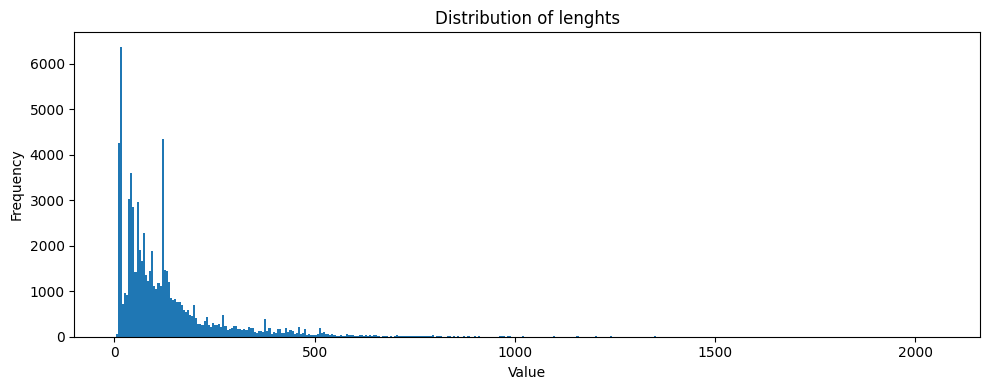

In [29]:
plt.figure(figsize=(10,4))
plt.hist(lengths, bins="auto")  # automatic binning for a sensible histogram
plt.title("Distribution of lenghts")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### **Planing next stage**
##### The embedding model I will use to build RAG system is sentence-transformers/all-MiniLM-L6-v2
##### "max_position_embeddings": 512 is the context length. That means we can feed maximum 512 tokens to it, otherwise it will truncate the input.
##### As per the distribution plot, most of lengths are lower than 500. So I think 500 might be the max chunking size for RAG. We sill see........

In [30]:
out_path = Path(r"datasets\cleaned_medicine_data.json")
out_path.parent.mkdir(parents=True, exist_ok=True)  # make folder if needed

with out_path.open("w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)